In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

Created WidebandSignal with 1.0 MHz total bandwidth and 102400 samples per step


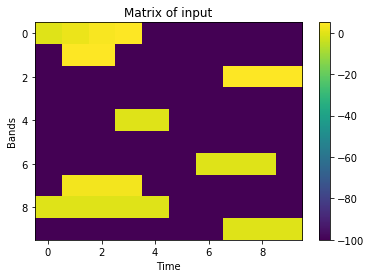

In [10]:
length = 1.024 # in seconds

wbs = ss.WidebandSignal(t_sec=length, num_bands=10, num_steps=10)

# One creates the matrix with the time axis vertical and the bands horizontal.
# Most of the plots below rotate the matrix 90 degree counterclockwise.

# mat = np.array([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
#                 [-100,    0, -100, -100, -100, -100, -100, -100,   10, -100],
#                 [-100,    0, -100,    5, -100, -100, -100, -100,   10, -100],
#                 [-100,    0, -100,    5, -100,   10, -100, -100,   10, -100],
#                 [-100,    0, -100,    5, -100,   10, -100, -100, -100, -100],
#                 [-100,    0, -100,    5, -100,   10, -100, -100, -100, -100],
#                 [-100,    0, -100,    5, -100,   10, -100, -100, -100, -100],
#                 [-100,    0, -100,    5, -100,   10, -100,    5, -100, -100],
#                 [-100,    0, -100,    5, -100, -100, -100,    5, -100, -100],
#                 [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

mat = np.array([[-100,    0, -100, -100, -100, -100, -100, -100, -100,    0],
                [-100,    0,    3, -100, -100, -100, -100, -100,    5,    2],
                [-100,    0,    3, -100, -100, -100, -100, -100,    5,    4],
                [-100,    0,    3, -100, -100,    0, -100, -100, -100,    5],
                [-100,    0, -100, -100, -100,    0, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100,    0, -100, -100, -100, -100, -100, -100],
                [   0, -100, -100,    0, -100, -100, -100,    5, -100, -100],
                [   0, -100, -100,    0, -100, -100, -100,    5, -100, -100],
                [   0, -100, -100, -100, -100, -100, -100,    5, -100, -100]])

# Plot the input signal matrix
ss.util_wide.plot_matrix(mat, title='input')

# Create wideband signal
sig, sample_freq = wbs.get_signal(mat)

# Create noise signal
noise_power = -10.
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.get_signal(power=noise_power, dB=True)

assert wbs.num_samples == wgn.num_samples  # ensure noise and signal have same length
num_samples = wbs.num_samples

both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

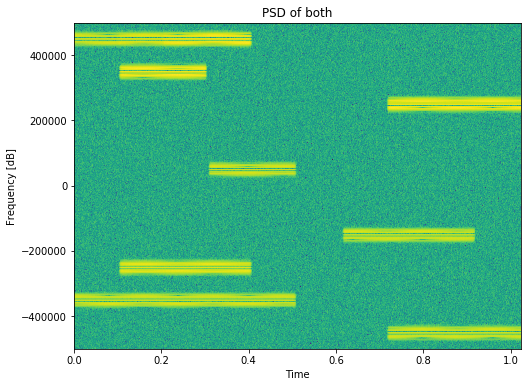

In [11]:
# Plot the wideband signal in 2d
ss.plot2d(both,
          sample_freq,
          window='flattop',
          nfft=1024,
          dB=True,
          type='our',
          title='both')

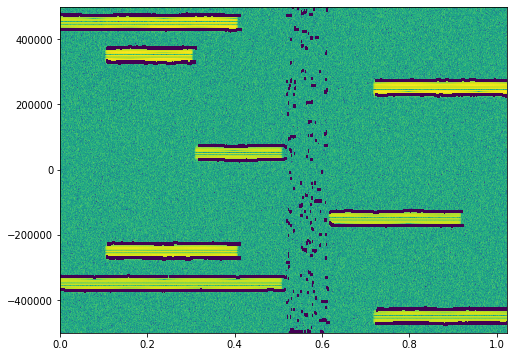

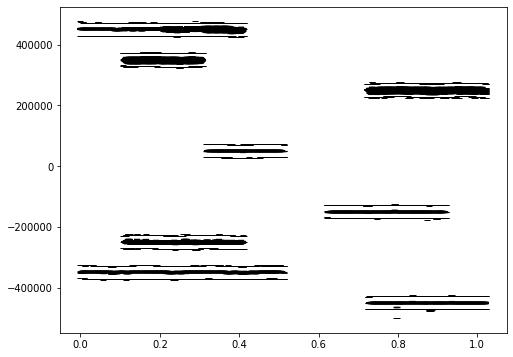

--- Raw:  {154.0: (23.177350183530425, 132, 176, 44), 973.0: (24.95589507603147, 951, 995, 44)}
Channel center freq: 154.00
Energy in channel:   23.18
Channel upper freq:  -371093.75
Channel lower freq:  -328125.00
Channel width:       -42968.75
--- Raw:  {154.0: (23.177350183530425, 132, 176, 44), 973.0: (24.95589507603147, 951, 995, 44)}
Channel center freq: 973.00
Energy in channel:   24.96
Channel upper freq:  428710.94
Channel lower freq:  471679.69
Channel width:       -42968.75


In [12]:
# Use edge detection in spectrum in oder to detect spectrum areas of interest

# Number of fft bins
nfft=1024

# Fourier transform of signal
sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

# Variable Band Frequency Energy Detector
ved = ss.VariableBandFreqEnergyDetector(f_sample=sample_freq,
                                        fft_len=nfft,
                                        freqs=f,
                                        noise_power=noise_power,
                                        pfa=0.1, 
                                        smooth=10., 
                                        scale=5, 
                                        min_height=0.2)

# Empty overlay picture of edges in spectrum
res = np.empty(shape=(len(f), len(t)))
res[:] = np.nan

# Empty detection results
det = np.array([])

# Loop over spectrum and detect
for i, _ in enumerate(t):

    # Do actual detection
    ps, peak, peakf, dics = ved.detect(x[:, i])

    # Store edges in res
    res = ss.util_wide.store_pic(pic=res,
                                 x=i,
                                 y=peak,
                                 n=3,
                                 val=1.,
                                 minimum=0,
                                 maximum=len(f))

    # Store detection results in det
    det = np.append(det, dics)

# Plot spectrum and edges in one picture
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               ss.util.dB_power(x),
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(ss.util.dB_power(x)),
               vmax=np.max(ss.util.dB_power(x)))
plt.pcolormesh(t, f, res, shading='flat', cmap='viridis', snap=True)
plt.show()

# Plot detection results
plt.figure(figsize=(8, 6))
for i, dic in enumerate(det):
    for j, d in enumerate(dic.items()):
        plt.plot(t[i], f[int(d[1][1])], 'k_')
        plt.plot(t[i], f[int(d[0])], 'k_', markeredgewidth=d[1][0] / 10)
        plt.plot(t[i], f[int(d[1][2])], 'k_')
plt.show()

# Print some channel stats
for j, d in enumerate(det[100].items()):
    print('--- Raw: ', det[100])
    print('Channel center freq: %.2f' % (d[0]))
    print('Energy in channel:   %.2f' % (d[1][0]))
    print('Channel upper freq:  %.2f' % (f[d[1][1]]))
    print('Channel lower freq:  %.2f' % (f[d[1][2]]))
    print('Channel width:       %.2f' % (d[1][3] * (f[0] - f[1])))